## Dependencies

In [7]:
import sys
import os
sys.path.append('C:\\Users\oscar\OneDrive\Dokumenter\Høst 2023\TET4510 Spesialiseringsprosjekt\Preliminary-project') #OSCAR path
#sys.path.append('C:\\Users\\benny\\Documents\\Preliminary-project')  #BENJAMIN path
#sys.path.append('C:\\Users\\Epsilon Delta\\OneDrive - NTNU\\Energi og Miljø NTNU\\Høst2023\\TET4565 Fordypningsemne\\Hydro_optimization') #ESPEN path

import pyomo.environ as pyo
import numpy as np
from pyomo.environ import ConcreteModel,Set,RangeSet,Param,Suffix,Reals,NonNegativeReals,NonPositiveReals,Binary,Objective,minimize,maximize,value
from pyomo.core import Constraint,Var,Block,ConstraintList
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.environ import ConstraintList
from pyomo.dae import *
from calculations.datahandling import*
from calculations.data_processor import* 
import itertools
import matplotlib.pyplot as plt

## Reading in parameters and topology data

In [8]:
# ---------------------------- Read in parameters and hydro topology -------------------------------------- # WE WAIT WITH THIS UNTIL LATER

def InputParameter(data_file):
    inputdata = pd.read_excel(data_file)
    inputdata = inputdata.set_index('Parameter', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['prod'] = inputdata[['Ci', 'yi', 'P_min', 'P_max']]
    data['prod'].drop('Solar', inplace=True)
    return data

parameters=InputParameter('data/Parameters.xlsx')


def InputTopology(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Hydro')
    inputdata = inputdata.set_index('Ormsetfoss', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['ormset'] = inputdata[['Pmin', 'Pmax','Vmax','Vmin','Vstart','Qmin','Qmax','Pump_min','Pump_max', 'Q','LRL','HRL','RL_start', 'Spill_min', 'Spill_max']].dropna()
    return data 
topology = InputTopology('data/Ormset_Data.xlsx')

    #Volume-head relationship:
def InputHead(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Vol_head')
    volume_column='Mm3'
    head_column='m'
    data_volhead = dict(zip(inputdata[volume_column], inputdata[head_column]))
    return data_volhead
headvol_Ormset=InputHead('data/Ormset_Data.xlsx')

def InputHead2(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Vol_head2')
    volume_column='Mm3'
    head_column='m'
    data_volhead = dict(zip(inputdata[volume_column].dropna(), inputdata[head_column].dropna()))
    return data_volhead
headvol_Buaset=InputHead2('data/Ormset_Data.xlsx')

    #Flow-head relationship:
def InputFlow(data_file): 
    inputdata = pd.read_excel(data_file, sheet_name='flow')
    data_flowhead = {}
    data_flowhead['ormset_headflow'] = inputdata[['Moh','m3/s']].dropna()
    return data_flowhead
headflow=InputFlow('data/Ormset_Data.xlsx')

display(topology)
display(headvol_Ormset)
display(headflow)

def interpolate_head(volume, head_dict):
    volumes = list(head_dict.keys())
    heads = list(head_dict.values())
    return np.interp(volume, volumes, heads)

test=interpolate_head(45, headvol_Ormset)
print(test)


FileNotFoundError: [Errno 2] No such file or directory: 'data/Parameters.xlsx'

In [ ]:
start = '2019-09-01 00:00:00'
end = '2020-08-31 23:00:00'
start_dt = pd.to_datetime(start)
end_dt = pd.to_datetime(end)

    #Input data and read-in
input_data_market = read_csv_data('data/Market_price.csv')              #MARKET
market_prices_h=convert_to_dict(input_data_market, start, end, 'H') ##avg_market_price=average_value(market_prices_h)
avg_market_price=average_value(market_prices_h)

input_data_inflow = read_csv_data('data/Data_inflow.csv')
columns = ['Ormsetvatn','Buavatn']
inflow = convert_to_dict(input_data_inflow, start, end, 'H', columns)
inflow_hydro1 = inflow[0]  # First dictionary for Hydro1 - ORMSETVATN
inflow_hydro2 = inflow[1]  # Second dictionary for Hydro2 - BUAVATN

input_data_load= read_csv_data('data/Normal_consumption.csv')
load_unscaled=convert_to_dict(input_data_load, start, end, 'H')
load_h=scale_dict(load_unscaled, 0.008)

hours_difference = ((end_dt - start_dt).total_seconds() / 3600)+1  # 3600 seconds in an hour

print(load_h[8568])
print(inflow_hydro1[3565])

65.91732719267053
30.48


## Functions


In [ ]:


# Define your input data and constants
#L = {1: 30, 2: 20, 3: 20, 4: 30, 5: 50, 6: 80, 7: 50, 8: 90, 9: 110, 10: 150, 11: 120, 12: 80, 13: 70, 14: 80, 15: 90, 16: 160, 17: 170, 18: 150, 19: 120, 20: 100, 21: 70, 22: 60, 23: 50, 24: 40}

constants = {'eff': 0.91, 'rho': 1000, 'g': 9.81, 'Ri': 30, 'Si': 300, 
             'inflow_scenarios' : ['High', 'Avg', 'Low'], 
             'inflow_probabilities' : {'High': 1/3, 'Avg': 1/3, 'Low': 1/3}, 
             'states': {100: 1, 75: 0.75, 50: 0.5, 25: 0.25, 0:0 }}




# Variables for power produced or bought and volume, water level etc.
def p_bounds(model, i, j, s):
    return (model.Pmin[i], model.Pmax[i])

def q_bounds(model, i, j, s): #flow rate
    return (model.Qmin[i], model.Qmax[i])

def pump_bounds(model, i, j, s):
    return(model.Pump_min[i], model.Pump_max[i])

def vol_bounds(model, i, j, s ):
    return (model.Vmin[i], model.Vmax[i])

def init_v(model, i, j, s):
    return model.v0[i]

def head_bounds(model,i,j, s):
    return (model.LRL[i], model.HRL[i])

def spill_bounds(model, i, j, s):
    return (model.S_min[i], model.S_max[i])

#initializing scenarios for inflow

def inflow1_scenario(model, i, j, s):
    if i=='Hydro1':
        if s == 'High': 
            return model.inflow[i,j,s]==scale_dict(inflow_hydro1, 1.1)[j]
        elif s == 'Avg':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro1, 1)[j]
        elif s == 'Low':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro1, 0.9)[j]
    elif i == 'Hydro2':
        if s == 'High': 
            return model.inflow[i,j,s]==scale_dict(inflow_hydro2, 1.1)[j]
        elif s == 'Avg':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro2, 1)[j]
        elif s == 'Low':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro2, 0.9)[j]


# Constraints
def load_rule(model, j, s):
    return model.p['Hydro1',j, s] + model.p['Hydro2',j, s] + model.m['Buy',j, s] == model.L[j] - (model.r[j, s])

def power_rule(model,i, j, s):   #Rule for hydro power production dependent on varying discharge #update to also vary on head
    return  10**-6*model.eff * model.rho * model.g * model.HRL[i] * model.q[i, j, s] == model.p[i, j, s]#MW

def vol_rule(model, i, s):
    tolerance = 1e1  # Adjust the tolerance value as needed (so that volume does not HAVE to be full if we simulate over a small time period)
    return model.v[i, min( model.periods), s ] >= model.v0[i] - tolerance



# Hydro parameters
fm3 = 3600/1000000 # Conversion factor between m^3/s and Mm^3/hour. 1h = 3600s and M = 10^6.
# Constraint to update volume based on cumulative sum of discharges (VOLUME [MM3] - DISCHARGE [MM3/h] + INFLOW [MM3/h])
# Constraint to update volume based on cumulative sum of discharges (VOLUME [MM3] - DISCHARGE [MM3/h] + INFLOW [MM3/h])


#def v_init_rule(model, i, v):
   #return model.v_init[i,v]==model.v0[i]*v/100


    
def volume_change_rule(model, i, j, s):  
    if j == min(model.periods): 
        if i == 'Hydro1':
            return model.v[i, j , s] == (model.v_init1) - (model.q[i, j, s] *fm3) + (model.inflow[i,j,s]*fm3) + (model.pump['Hydro2',j, s]*fm3) -(model.s[i,j,s]*fm3)
        elif i == 'Hydro2':
        # Include the discharge from Hydro1 as inflow to Hydro2 
            return model.v[i, j, s] == (model.v_init2) - (model.q[i, j, s] *fm3) + (model.inflow[i,j,s]*fm3) -(model.s[i,j,s]*fm3)
    else: 
        if i =='Hydro1': 
            return model.v[i, j , s] == model.v[i,j-1,s] - (model.q[i, j, s] *fm3) + (model.inflow[i,j,s]*fm3) +(model.pump['Hydro2',j, s]*fm3) -(model.s[i,j,s]*fm3)
        elif i =='Hydro2':
            return model.v[i, j, s] == model.v[i,j-1,s] - (model.q[i, j, s] *fm3) + (model.inflow[i,j,s]*fm3) -(model.s[i,j,s]*fm3)   
        
        
    
         
    
def OBJ_one_stage(model):
    return sum(model.probs[s] * (model.Ri*model.r[j, s] + model.Mi[j] * model.m['Buy', j, s]) for j in model.periods for s in model.scenarios ) + model.alpha


def OBJ_last_stage(model):
    return sum(model.probs[s] * (model.Ri*model.r[j, s] + model.Mi[j] * model.m['Buy', j, s]) for j in model.periods for s in model.scenarios )




## Solve one stage setup


In [ ]:
def solve_last_stage(constants, topology, stage, states):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="SDP")

    # Define the inflow scenarios and associated probabilities
    model.scenarios=pyo.Set(initialize=constants['inflow_scenarios'])
    
    
    
    # Sets to model hydro topology
    model.periods = pyo.Set(initialize= range ((stage-1)*7*24, (stage)*7*24 + 1, 1))
                      #these sets must be defined in the latex report as well
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])               #uses i
    model.market = pyo.Set(initialize=['Buy','Sell'])


    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])

    
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])
    model.v_init1=pyo.Param(initialize=states[0])
    model.v_init2=pyo.Param(initialize= states[1])

    #Scenario parameter
    model.probs=pyo.Param(model.scenarios, initialize=constants['inflow_probabilities'])
    
    
    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods, model.scenarios,  within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods, model.scenarios,   bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods, model.scenarios, within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods, model.scenarios,  bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods, model.scenarios,  within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods, model.scenarios, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods, model.scenarios, bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    model.r=pyo.Var( model.periods, model.scenarios, within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods, model.scenarios, bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
 
    #--- CONSTRAINTS---
    model.inflow_cons=pyo.Constraint(model.plants,  model.periods, model.scenarios,  rule=inflow1_scenario)
    model.load_cons = pyo.Constraint( model.periods, model.scenarios,  rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods, model.scenarios, rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods, model.scenarios, rule=volume_change_rule)
    
    # --- Objective function---
    model.obj=pyo.Objective(rule=OBJ_last_stage, sense=pyo.minimize)
    
        
    return model
    


def solve(model):
    #solver 
    opt = SolverFactory('gurobi', solver_io="python") 
    #opt.options['NonConvex']=2    #defining dual 
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    results = opt.solve(model,tee=True) 
            
    return results, model

def displayresults(model):
    return print(model.dual.display())




In [ ]:
stages=reversed(range(1, 52 + 1, 1))
scenarios= ['High', 'Avg', 'Low']
Hydro1_initial=[i for i in range (0, 45+9, 9)]
Hydro2_initial=[i for i in range (0, 20+4, 4)]   
state_combinations =[p for p in itertools.product(Hydro1_initial, Hydro2_initial)]

expected={}
end_volume1={}
end_volume2={}
Dual_values1={}
Dual_values2={}
for state in state_combinations: 
        m=solve_last_stage(constants, topology, 52, state)
        solve(m)
        expected[52,state]=m.obj()/len(m.scenarios)
        end_volume1[52, state]= (m.v['Hydro1', max(m.periods), 'High'].value + m.v['Hydro2', max(m.periods), 'Avg'].value + m.v['Hydro2', max(m.periods), 'Low'].value)/len(m.scenarios)
        end_volume2[52, state]= (m.v['Hydro2', max(m.periods), 'High'].value + m.v['Hydro2', max(m.periods), 'Avg'].value + m.v['Hydro2', max(m.periods), 'Low'].value)/len(m.scenarios)
        Dual_values1[52, state]= (m.dual.get(m.volume_change_cons['Hydro1', max(m.periods), 'High']) + m.dual.get(m.volume_change_cons['Hydro1', max(m.periods), 'Avg']) + m.dual.get(m.volume_change_cons['Hydro1', max(m.periods), 'Low']))/len(m.scenarios)
        Dual_values2[52, state]= (m.dual.get(m.volume_change_cons['Hydro2', max(m.periods), 'High']) + m.dual.get(m.volume_change_cons['Hydro2', max(m.periods), 'Avg']) + m.dual.get(m.volume_change_cons['Hydro2', max(m.periods), 'Low']))/len(m.scenarios)
        print(state[0], state[1])



Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3549 rows, 8619 columns and 10641 nonzeros
Model fingerprint: 0x23b08a75
Coefficient statistics:
  Matrix range     [4e-03, 3e+00]
  Objective range  [3e-01, 1e+01]
  Bounds range     [2e+00, 1e+07]
  RHS range        [5e-02, 8e+01]
Presolve removed 2385 rows and 6453 columns
Presolve time: 0.03s
Presolved: 1164 rows, 2166 columns, 3534 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8115418e+04   6.878420e+02   0.000000e+00      0s
    1303    1.7307113e+05   0.000000e+00   0.000000e+00      0s

Solved in 1303 iterations and 0.06 seconds (0.01 work units)
Optimal objective  1.730711318e+05
0 0
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (

In [ ]:
print(expected)
print(end_volume1)
print(end_volume2)
print(Dual_values1)
print(Dual_values2)


{(52, (0, 0)): 57553.85573008433, (52, (0, 4)): 25876.809866939595, (52, (0, 8)): 15694.904276124471, (52, (0, 12)): 15694.904276124471, (52, (0, 16)): 15694.904276124471, (52, (0, 20)): 15694.904276124471, (52, (9, 0)): 43410.740602887985, (52, (9, 4)): 11788.52246803856, (52, (9, 8)): 4441.473386600045, (52, (9, 12)): 4441.473386600045, (52, (9, 16)): 4441.473386600045, (52, (9, 20)): 4441.473386600045, (52, (18, 0)): 43410.740602888, (52, (18, 4)): 11788.52246803856, (52, (18, 8)): 4441.473386600045, (52, (18, 12)): 4441.473386600045, (52, (18, 16)): 4441.473386600045, (52, (18, 20)): 4441.473386600045, (52, (27, 0)): 43410.74060288799, (52, (27, 4)): 11788.52246803856, (52, (27, 8)): 4441.473386600045, (52, (27, 12)): 4441.473386600045, (52, (27, 16)): 4441.473386600045, (52, (27, 20)): 4441.473386600045, (52, (36, 0)): 43410.74060288798, (52, (36, 4)): 11788.52246803856, (52, (36, 8)): 4441.473386600045, (52, (36, 12)): 4441.473386600045, (52, (36, 16)): 4441.473386600045, (52, (3

In [ ]:
def solve_one_stage(constants, topology, stage, states, alpha_values, dual_res1, dual_res2):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="SDP")

    # Define the inflow scenarios and associated probabilities
    model.scenarios=pyo.Set(initialize=constants['inflow_scenarios'])
    
    
    
    # Sets to model hydro topology
    model.periods = pyo.Set(initialize= range ((stage-1)*7*24, (stage)*7*24 + 1, 1))
                      #these sets must be defined in the latex report as well
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])               #uses i
    model.market = pyo.Set(initialize=['Buy','Sell'])


    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])

    
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])
    model.v_init1=pyo.Param(initialize=states[0])
    model.v_init2=pyo.Param(initialize= states[1])

    #Scenario parameter
    model.probs=pyo.Param(model.scenarios, initialize=constants['inflow_probabilities'])
    
    
    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods, model.scenarios,  within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods, model.scenarios,   bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods, model.scenarios, within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods, model.scenarios,  bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods, model.scenarios,  within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods, model.scenarios, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods, model.scenarios, bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    model.r=pyo.Var( model.periods, model.scenarios, within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods, model.scenarios, bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
    
    #Creating future cost variable
    model.alpha=pyo.Var()
 
    #--- CONSTRAINTS---
    model.inflow_cons=pyo.Constraint(model.plants,  model.periods, model.scenarios,  rule=inflow1_scenario)
    model.load_cons = pyo.Constraint( model.periods, model.scenarios,  rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods, model.scenarios, rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods, model.scenarios, rule=volume_change_rule)
    
    # Creating a constraint list for the FCF
    model.alpha_cons=pyo.ConstraintList()
    
    # List to store expected cost from previous stage
    phi_values = []
    
    #List to store dual value of reservoir 1 & 2 in previous stage
    lambda1_values = []
    lambda2_values = []

    #List to store initial volumes introduced in states
    state_volumes=[]
    
    #Appending values for previous stage 
    for key in alpha_values:
        if key[0]==stage+1:
            state_volumes.append(key[1])
            phi_values.append(alpha_values[key])
            lambda1_values.append(dual_res1[key])
            lambda2_values.append(dual_res2[key])
        else:
            pass
    
    # Calculate the FCF for each discrete point and constrain alpha through cuts: a>= phi - lambda1*(x1-x1_hat) - lambda2*(x2-x2_hat) for each state, where x1 is the average end-of-stage volume for all scenarios
    for i in range(len(state_volumes)):
        model.alpha_cons.add(model.alpha >= phi_values[i] - lambda1_values[i]*((model.v['Hydro1', max(model.periods),'High'] + model.v['Hydro1', max(model.periods),'Avg'] + model.v['Hydro1', max(model.periods),'Low'])/len(model.scenarios)- (state_volumes[i][0])) - lambda2_values[i]*((model.v['Hydro2', max(model.periods), 'High'] + model.v['Hydro2', max(model.periods), 'Avg'] + model.v['Hydro2', max(model.periods), 'Low'])/len(model.scenarios)  - (state_volumes[i][1])))
        
    # --- Objective function---
    
    
    model.obj=pyo.Objective(rule=OBJ_one_stage, sense=pyo.minimize)
    
        
    return model
    

In [ ]:
stages=reversed(range(49, 51 + 1, 1))
scenarios= ['High', 'Avg', 'Low']
Hydro1_initial=[i for i in range (0, 45+9, 9)]
Hydro2_initial=[i for i in range (0, 20+4, 4)]   
state_combinations =[p for p in itertools.product(Hydro1_initial, Hydro2_initial)]

alpha_dict={}
for stage in stages:
    for state in state_combinations:
        m2=solve_one_stage(constants, topology, stage, state, expected, Dual_values1, Dual_values2)
        solve(m2)
        expected[stage, state]=(m2.obj()/len(m2.scenarios))
        end_volume1[stage, state]= (m2.v['Hydro1', max(m2.periods), 'High'].value + m2.v['Hydro2', max(m2.periods), 'Avg'].value + m2.v['Hydro2', max(m2.periods), 'Low'].value)/len(m2.scenarios)
        end_volume2[stage, state]= (m2.v['Hydro2', max(m2.periods), 'High'].value + m2.v['Hydro2', max(m2.periods), 'Avg'].value + m2.v['Hydro2', max(m2.periods), 'Low'].value)/len(m2.scenarios)
        Dual_values1[stage, state]= (m2.dual.get(m2.volume_change_cons['Hydro1', max(m2.periods), 'High']) + m2.dual.get(m2.volume_change_cons['Hydro1', max(m2.periods), 'Avg']) + m2.dual.get(m2.volume_change_cons['Hydro1', max(m2.periods), 'Low']))/len(m2.scenarios)
        Dual_values2[stage, state]= (m2.dual.get(m2.volume_change_cons['Hydro2', max(m2.periods), 'High']) + m2.dual.get(m2.volume_change_cons['Hydro2', max(m2.periods), 'Avg']) + m2.dual.get(m2.volume_change_cons['Hydro2', max(m2.periods), 'Low']))/len(m2.scenarios)
        alpha_dict[stage, state] = (m2.alpha.value)
        



Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3585 rows, 8620 columns and 10731 nonzeros
Model fingerprint: 0xdcb84884
Coefficient statistics:
  Matrix range     [4e-03, 2e+03]
  Objective range  [1e+00, 2e+01]
  Bounds range     [2e+00, 5e+01]
  RHS range        [9e-03, 6e+04]
Presolve removed 2535 rows and 5833 columns
Presolve time: 0.02s
Presolved: 1050 rows, 2787 columns, 4062 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.5976905e+04   1.170490e+03   0.000000e+00      0s
    1645    3.0727449e+05   0.000000e+00   0.000000e+00      0s

Solved in 1645 iterations and 0.04 seconds (0.01 work units)
Optimal objective  3.072744937e+05
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win6

C:\Users\oscar\AppData\Local\Temp\ipykernel_20924\2028895350.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("tab20")


<Figure size 2000x1200 with 0 Axes>

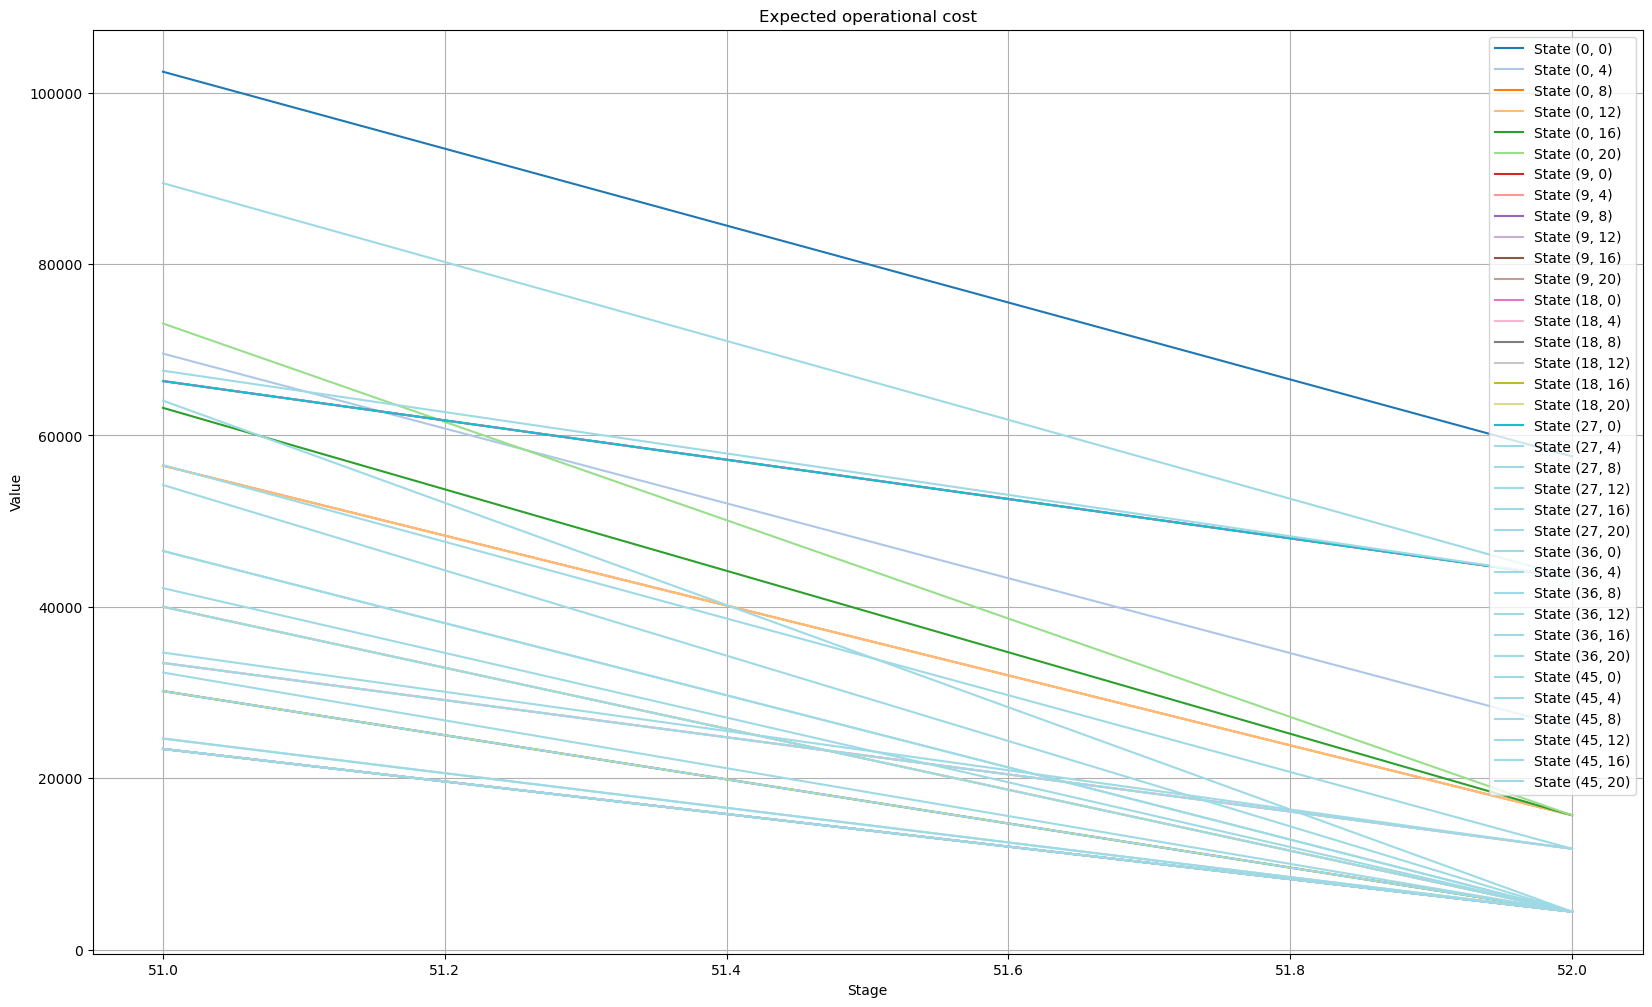

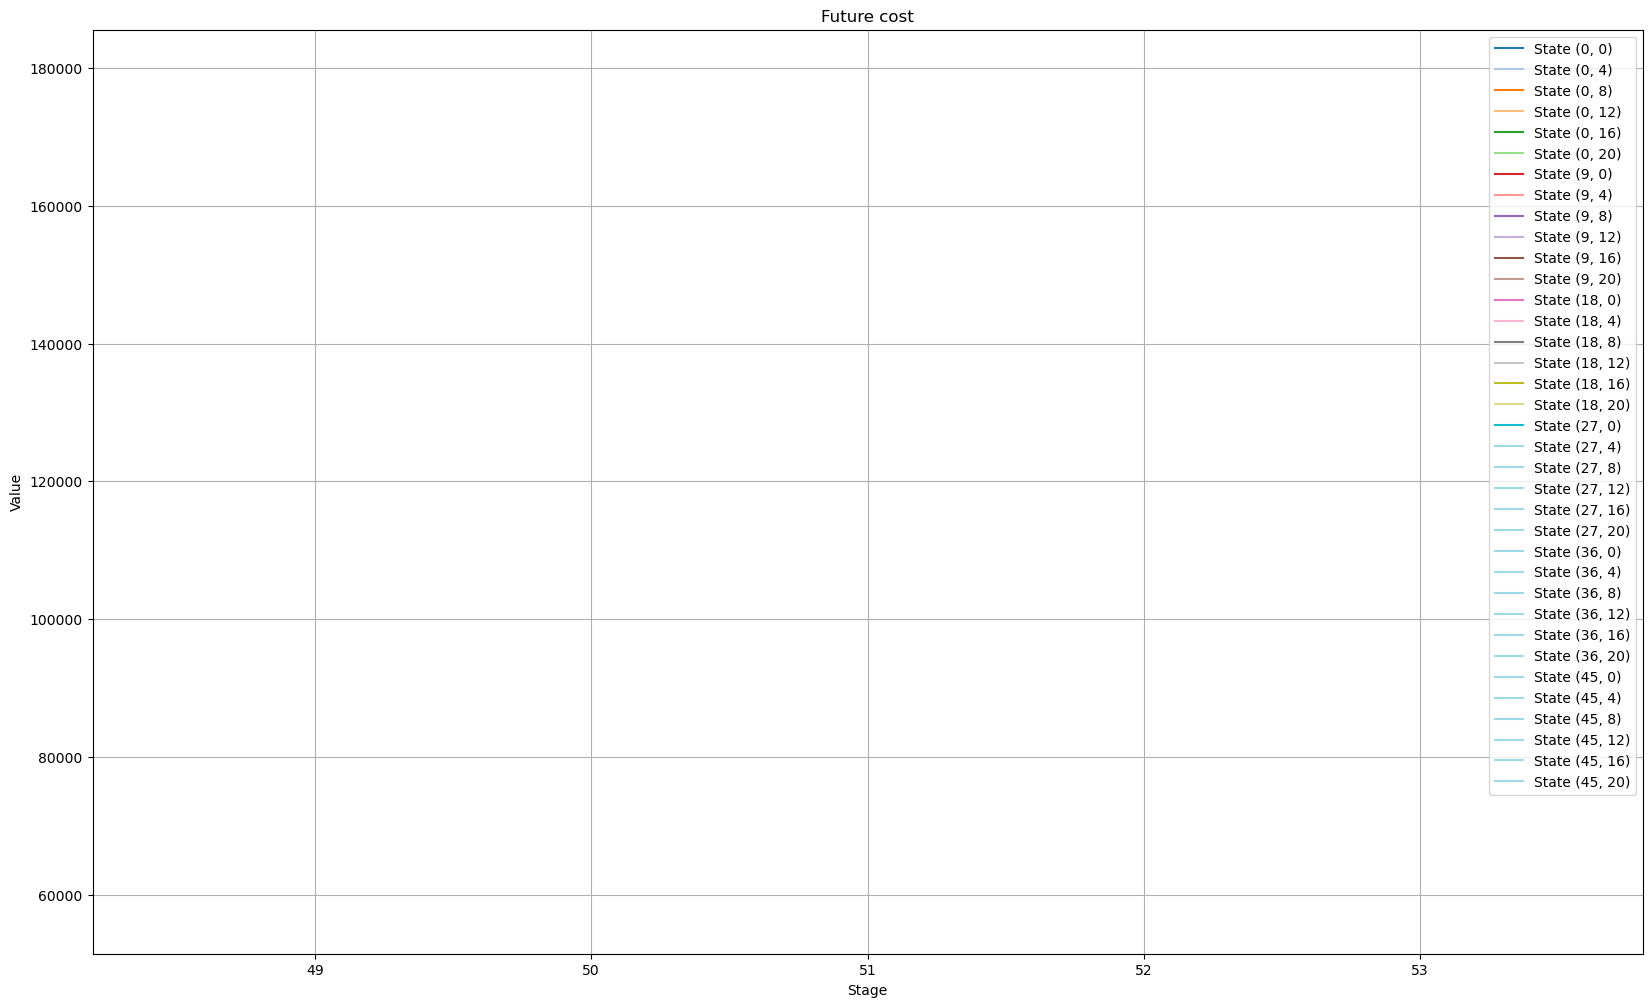

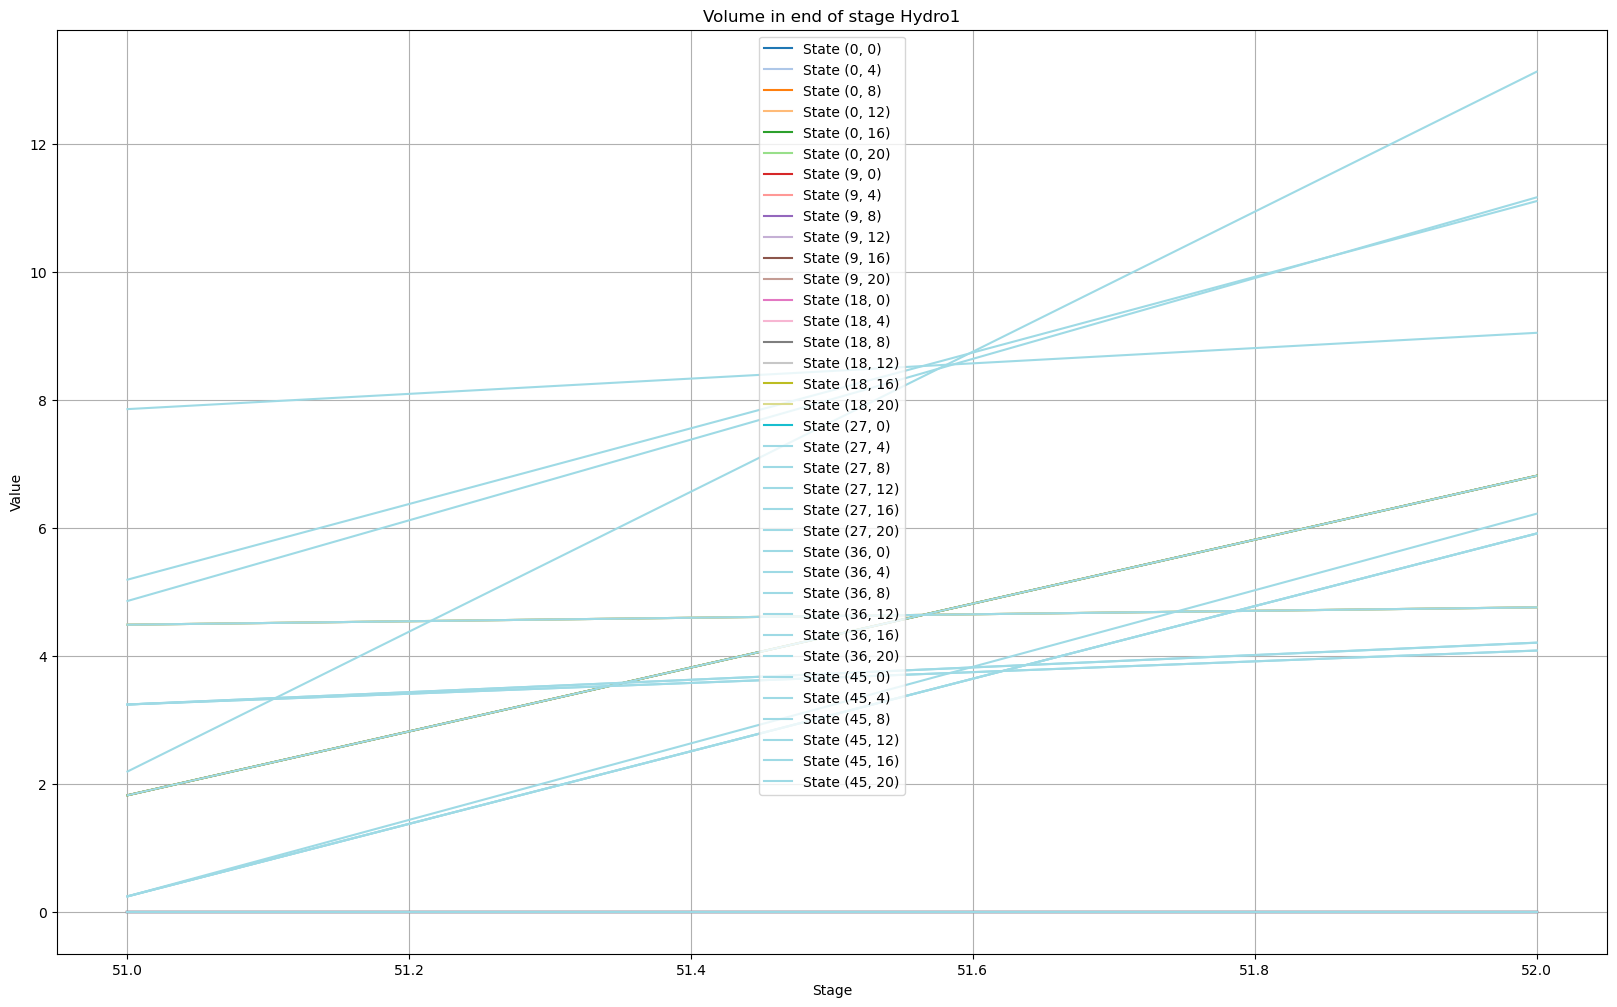

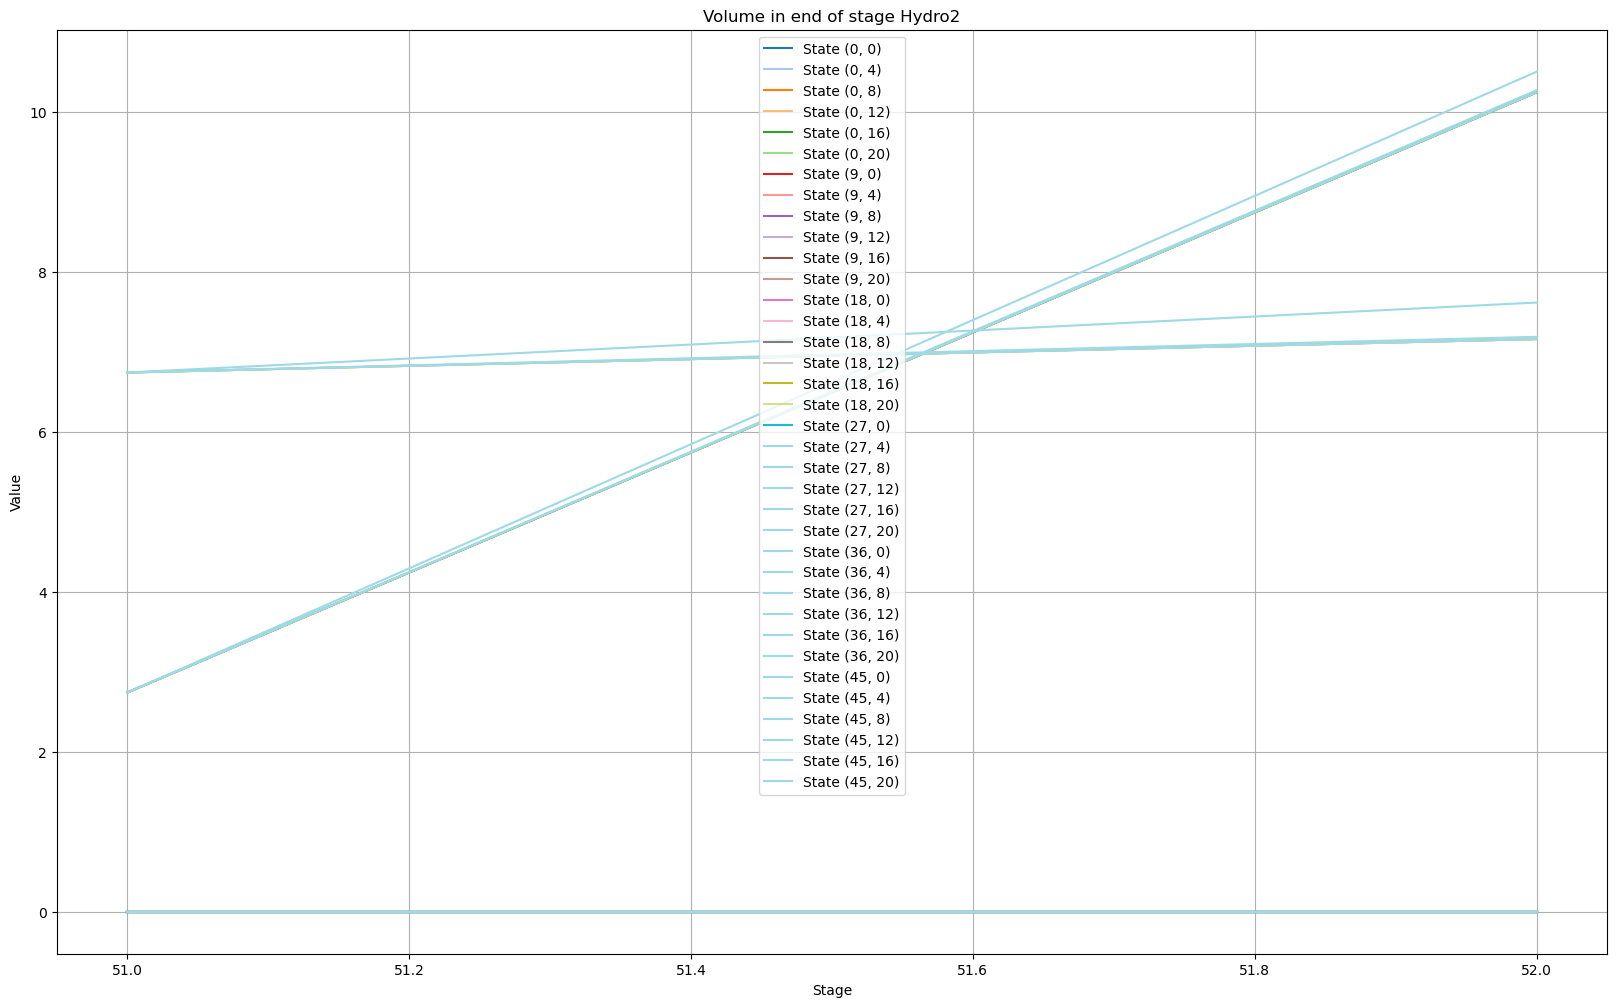

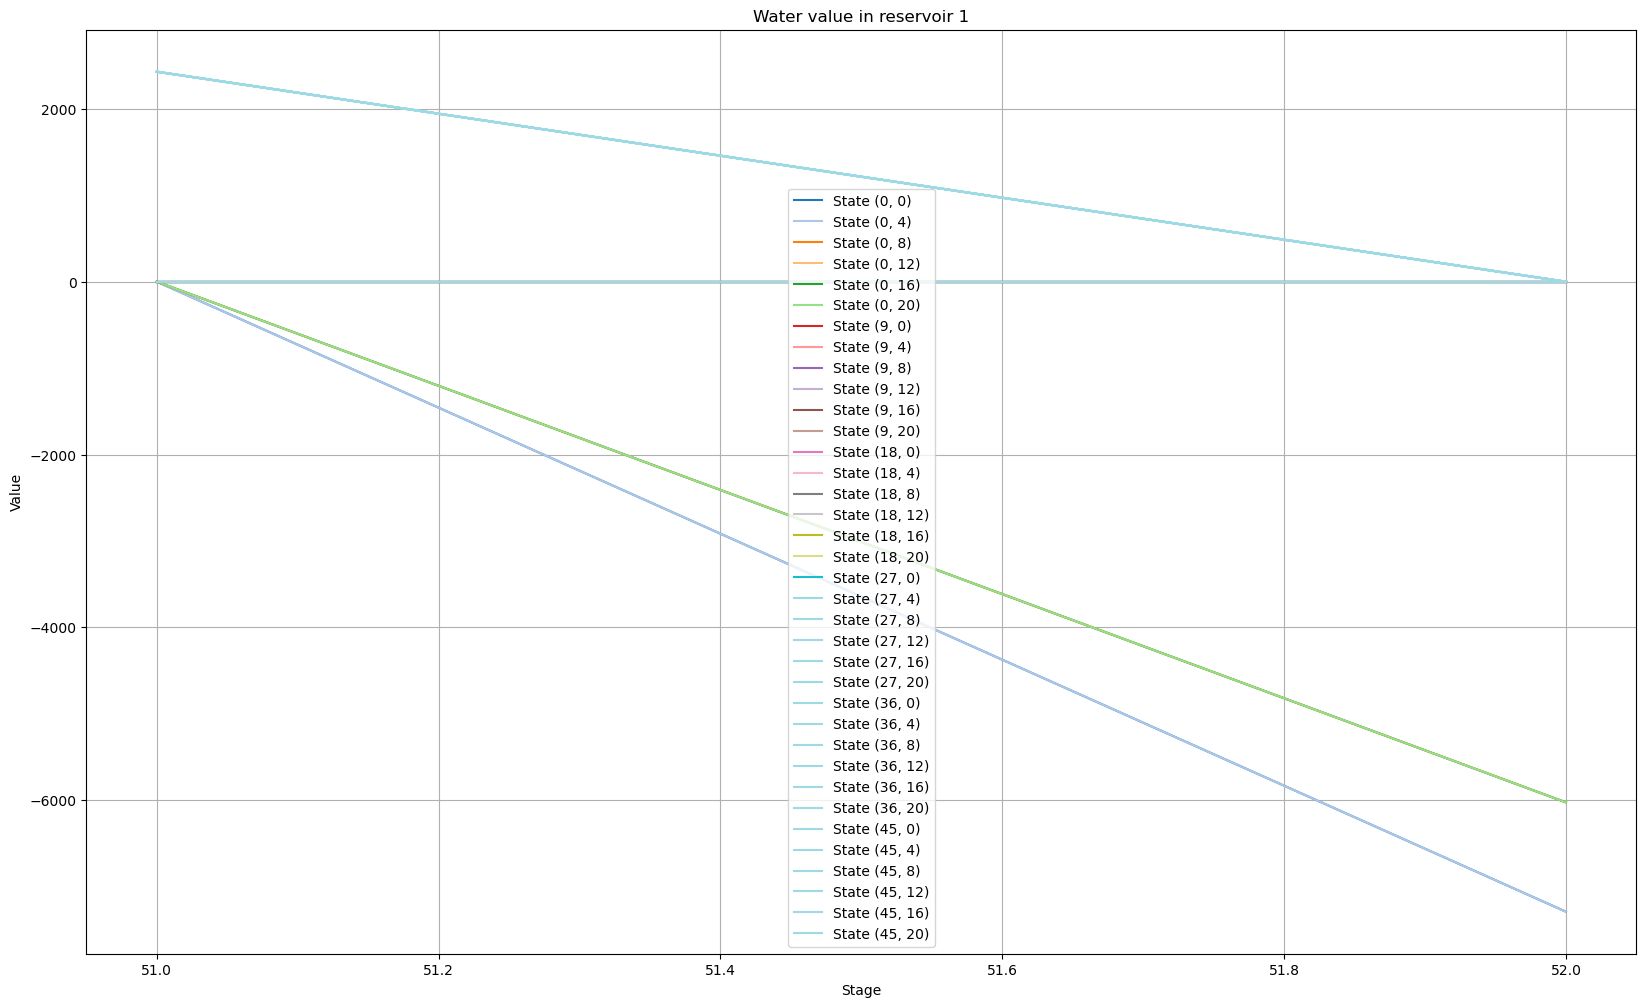

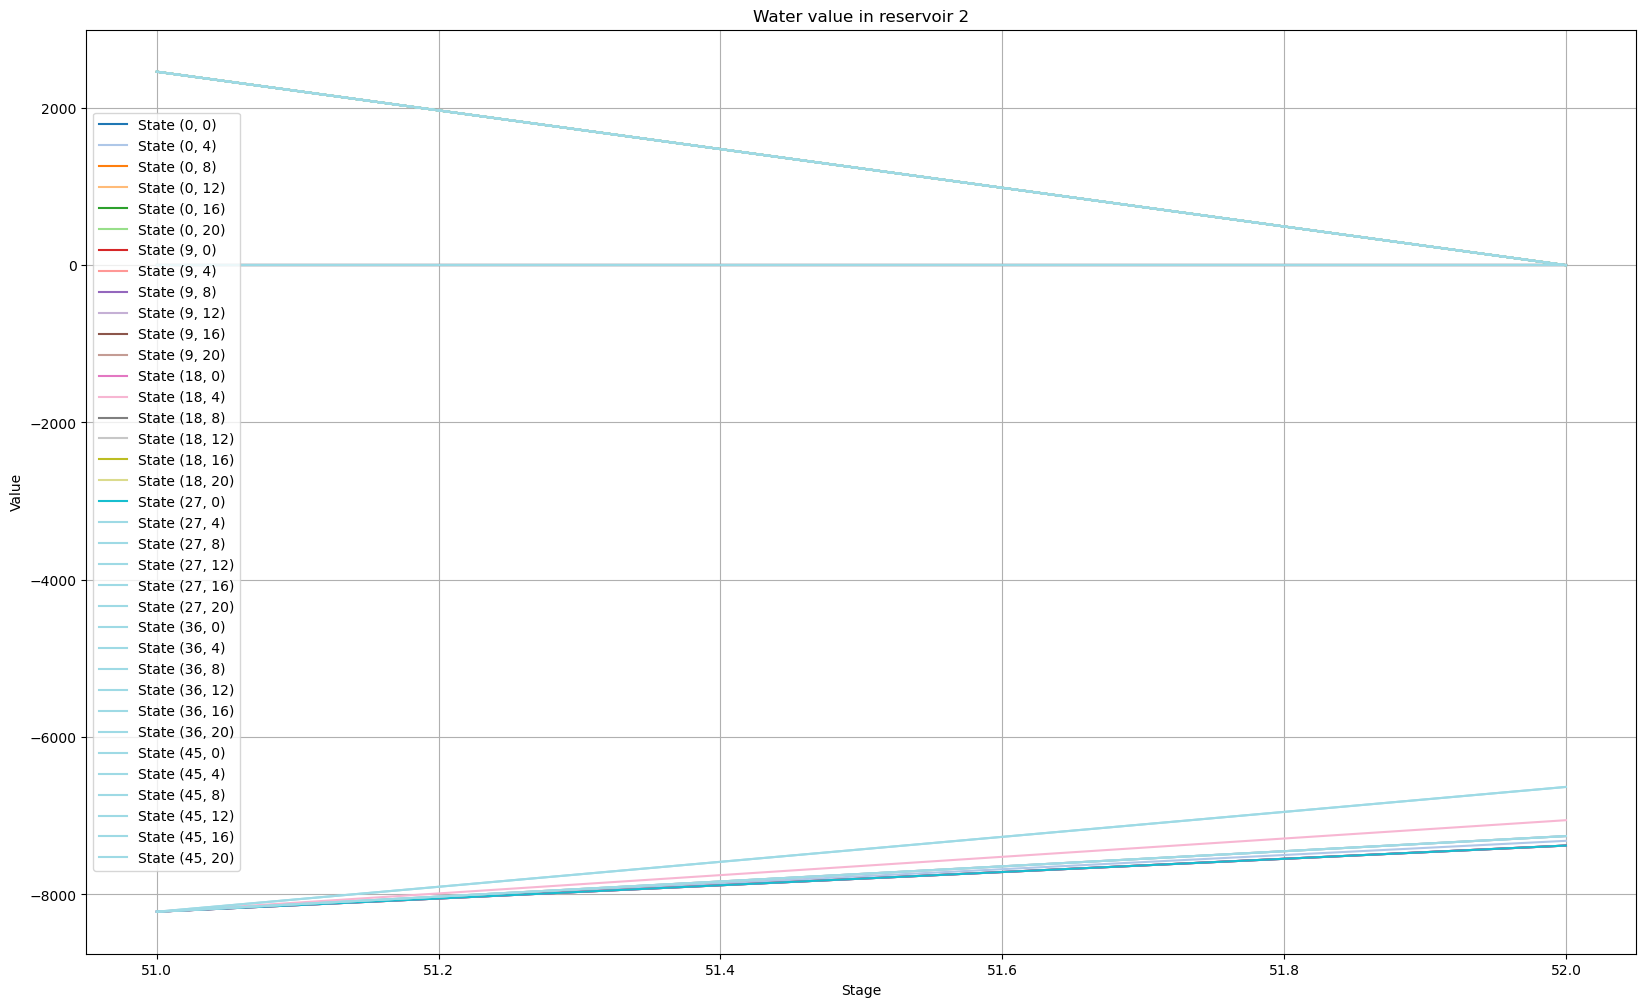

In [ ]:
from itertools import cycle
from matplotlib.cm import get_cmap

# Define your dictionaries and titles
dictionaries = [expected, alpha_dict, end_volume1, end_volume2, Dual_values1, Dual_values2]
titles = ["Expected operational cost", "Future cost", "Volume in end of stage Hydro1", "Volume in end of stage Hydro2", "Water value in reservoir 1", "Water value in reservoir 2"]

# Set a larger figure size
plt.figure(figsize=(20, 12))

# Define a cycle of colormaps for states
cmap = get_cmap("tab20")

# Iterate through the dictionaries
for dictionary, title in zip(dictionaries, titles):
    states = {}
    
    # Create a separate figure for each dictionary
    plt.figure(figsize=(20, 12))
    
    for key, value in dictionary.items():
        stage, state = key
        if state not in states:
            states[state] = {"stages": [], "values": []}
        states[state]["stages"].append(stage)
        states[state]["values"].append(value)
    
    # Plot each state with a different color
    for i, (state, data) in enumerate(states.items()):
        color = cmap(i)
        plt.plot(data["stages"], data["values"], label=f"State {state}", color=color)
    
    # Add labels, title, and legend for the current dictionary
    plt.xlabel("Stage")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

print(expected)

In [ ]:
print(alpha_dict)

{(51, (0, 0)): 57553.85573008433, (51, (0, 4)): 57553.85573008433, (51, (0, 8)): 57553.85573008433, (51, (0, 12)): 57553.85573008433, (51, (0, 16)): 77787.075888274, (51, (0, 20)): 107303.68892327433, (51, (9, 0)): 57553.85573008433, (51, (9, 4)): 57553.85573008433, (51, (9, 8)): 57553.85573008433, (51, (9, 12)): 57553.85573008433, (51, (9, 16)): 77787.075888274, (51, (9, 20)): 107303.68892327433, (51, (18, 0)): 57553.85573008433, (51, (18, 4)): 57553.85573008433, (51, (18, 8)): 57553.85573008433, (51, (18, 12)): 57553.85573008433, (51, (18, 16)): 77787.075888274, (51, (18, 20)): 107303.68892327433, (51, (27, 0)): 57553.85573008433, (51, (27, 4)): 57553.85573008433, (51, (27, 8)): 57553.85573008433, (51, (27, 12)): 57553.85573008433, (51, (27, 16)): 77787.075888274, (51, (27, 20)): 107303.68892327433, (51, (36, 0)): 61188.34496753295, (51, (36, 4)): 61188.34496753295, (51, (36, 8)): 61188.34496753295, (51, (36, 12)): 61188.34496753295, (51, (36, 16)): 84289.2455196377, (51, (36, 20)): 